# One-Hot Encoding, SMC, A workflow
In this document, we calculated Morgan Fingerprint for each reaction in SMC dataset, and then train them use Random forest, Linear Regression, XGBoost & neural network.

Next: DT -- regression, n-fold validation

In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
from rdkit.Chem import AllChem, MolFromSmiles
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem import DataStructs
from rdkit import Chem

c:\Users\Ran Tao\.conda\envs\edbo\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['Cl', 'C', '1', '=', 'C', 'C', '=', 'C', '(', 'O', 'C', ')', 'C', '=', 'C', '1', '.', 'O', 'B', '(', 'O', ')', 'C', '1', '=', 'C', 'C', '=', 'C', 'C', '=', 'C', '1', '>>', 'C', 'O', 'C', '(', 'C', '=', 'C', '1', ')', '=', 'C', 'C', '=', 'C', '1', 'C', '2', '=', 'C', 'C', '=', 'C', 'C', '=', 'C', '2']


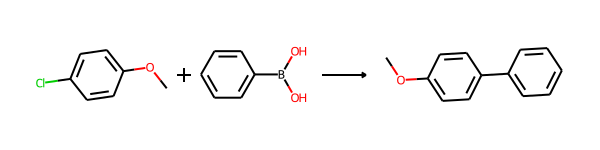

In [2]:
from rxnfp.tokenization import get_default_tokenizer, SmilesTokenizer
from rdkit.Chem import rdChemReactions

smiles_tokenizer = get_default_tokenizer()

reaction_smiles = 'ClC1=CC=C(OC)C=C1.OB(O)C1=CC=CC=C1>>COC(C=C1)=CC=C1C2=CC=CC=C2'
rxn = rdChemReactions.ReactionFromSmarts(reaction_smiles,useSmiles=True)

print(smiles_tokenizer.tokenize(reaction_smiles))
rxn

In [3]:
""""
def canonicalize_with_dict(smi, can_smi_dict={}):
    if smi not in can_smi_dict.keys():
        return Chem.MolToSmiles(Chem.MolFromSmiles(smi))
    else:
        return can_smi_dict[smi]
"""
    
def generate_ligand_data(df):
    #Convert the smiles of ligand to a dataframe.
    df = df.copy()
    
    #ligand_smiles_dict = {}
    rxns = []
    """
    The rxns is not useful now. When we use the whole rxn instead of ligand to predict, it will be convenient.
    To try with the entire rxn, tabulate all chemicals into a single column of dataframe.
    """
    smiles = df['Smiles']
    for i in smiles:
        try:
            ligand_smiles = Chem.MolFromSmiles(i)
            rxns.append(ligand_smiles)
        except:
            print(i)
        
    return rxns
   

# One-Hot Encoding SMC dataset

In [4]:
# Splitting data
from random import sample
import pandas as pd
from rdkit import Chem
#from rxn_yields.data import generate_buchwald_hartwig_rxns
#df = pd.read_excel('../data/Buchwald-Hartwig/Dreher_and_Doyle_input_data.xlsx', sheet_name='FullCV_01')
df_prep = pd.read_excel('smc_data.xlsx', sheet_name='SMC')
df_prep = df_prep.sample(frac=1,random_state=41)
df = pd.DataFrame()
df['text']= df_prep['Smiles']
df['Output'] = df_prep['II']

In [5]:
print(df)

                                                 text  Output
81                     N#Cc1ccccc1P(c1ccccc1)c1ccccc1       0
25  COc1ccc(OC)c(c1P(c2cc(cc(c2)C(F)(F)F)C(F)(F)F)...       1
83                                          OCP(CO)CO       0
63  CC(C)(C)P(c1ccccc1-n2nc(cc2-c3ccccc3)-c4ccccc4...       2
6                        CC(C)(C)CP(C(C)(C)C)C(C)(C)C       1
..                                                ...     ...
65                CC(C)(C)P(c1cccn1-c2ccccc2)C(C)(C)C       3
80         Cc1cc(C)cc(P(c2cc(C)cc(C)c2)c2ccccc2C=O)c1       0
12                        CC(C)(C)P(C1CCCCC1)C1CCCCC1       9
35                COc1ccc(P(c2ccc(OC)cc2)C2CCCCC2)cc1      57
64          CC(C)(C)P(c1cc2ccccc2n1-c3ccccc3)C(C)(C)C       3

[90 rows x 2 columns]


In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

enc = preprocessing.OneHotEncoder(sparse=False)
df_enc = enc.fit_transform(df)
print(df_enc.shape)


(90, 130)


# Cleaning up the SMC dataset
Train set: 0-71, validation set: 71-81, test set: 81-all

In [7]:
#df_enc is a LIST not Dataframe!! 
X_train,X_test = df_enc[:71],df_enc[71:]
print(X_train.shape,X_test.shape)


(71, 130) (19, 130)


In [8]:
mean = df.Output.mean()
std = df.Output.std()

y_train = ((df['Output'] - mean) / std).tolist()[:71]
y_test = ((df['Output'] - mean) / std).tolist()[71:]
df['Output'] = (df['Output'] - mean)/std


# Decision Tree Model

In [9]:
from sklearn.tree import DecisionTreeClassifier
Dt_clf = DecisionTreeClassifier(criterion = 'entropy')
dt_data = pd.cut(df.Output,bins=[-1,-0.5,0,0.5,1,5],labels=['Very Low','Low','Mediium','High','Very High'])
y_train_dt = dt_data[:71]
y_test_dt = dt_data[71:]
Dt_clf.fit(X_train, y_train_dt)

DecisionTreeClassifier(criterion='entropy')

In [10]:
from sklearn.metrics import accuracy_score
print('Accuracy Score on train data: ', accuracy_score(y_true=y_train_dt, y_pred=Dt_clf.predict(X_train)))
print('Accuracy Score on test data: ', accuracy_score(y_true=y_test_dt, y_pred=Dt_clf.predict(X_test)))

Accuracy Score on train data:  1.0
Accuracy Score on test data:  0.7368421052631579


# Random Forest Model

In [11]:
from sklearn.ensemble import RandomForestRegressor

RF_clf = RandomForestRegressor(max_features=0.8,min_impurity_decrease=0,min_samples_leaf=1,n_estimators=500)
RF_clf.fit(X_train, y_train)

RandomForestRegressor(max_features=0.8, min_impurity_decrease=0,
                      n_estimators=500)

In [12]:
from sklearn.metrics import mean_squared_error
forest_predictions = RF_clf.predict(X_train)
forest_mse = mean_squared_error(y_train, forest_predictions)
forest_rmse = np.sqrt(forest_mse)
print("Training set RMSE:",forest_rmse)

forest_predictions2 = RF_clf.predict(X_test)
forest_mse2 = mean_squared_error(y_test, forest_predictions2)
forest_rmse2 = np.sqrt(forest_mse2)
print("Test set RMSE:",forest_rmse2)


Training set RMSE: 0.41049211141617076
Test set RMSE: 0.794527500748434


In [13]:
from sklearn.metrics import r2_score
r2_score2=r2_score(y_train, forest_predictions)
print("Training set R^2:",r2_score2)
r2_score3=r2_score(y_test, forest_predictions2)
print("Test set R^2:",r2_score3)

Training set R^2: 0.8448011885035168
Test set R^2: -0.09401827733024803


In [14]:
from sklearn.model_selection import cross_val_score

cvd_scores = cross_val_score(RF_clf, df_enc, df['Output'], cv=5)
print('Cross Validation Score:',cvd_scores)

Cross Validation Score: [ 0.4586425   0.14631693 -0.61658364  0.13167643 -0.1311951 ]


# Linear Regression

In [39]:
from sklearn.linear_model import LinearRegression

reg_model = LinearRegression(n_jobs = None)
reg = reg_model.fit(X_train, y_train)
LinearRegression.get_params(reg, deep=True)

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

In [40]:
reg_predictions = reg.predict(X_train)
reg_mse = mean_squared_error(y_train, reg_predictions)
reg_rmse = np.sqrt(reg_mse)
print("Training set RMSE:",reg_rmse)

reg_predictions2 = reg.predict(X_test)
reg_mse2 = mean_squared_error(y_test, reg_predictions2)
reg_rmse2 = np.sqrt(reg_mse2)
print("Test set RMSE:",reg_rmse2)


regr2_score2=r2_score(y_train, reg_predictions)
print("Training set R^2:",regr2_score2)
regr2_score3=r2_score(y_test, reg_predictions2)
print("Test set R^2:",regr2_score3)

Training set RMSE: 1.5962727504239077e-15
Test set RMSE: 0.4969170800562711
Training set R^2: 1.0
Test set R^2: 0.5204652906300798


In [41]:
cvd_scores = cross_val_score(reg, df_enc, df['Output'], cv=5)
print('Cross Validation Score:',cvd_scores)

Cross Validation Score: [0.29534836 0.49978688 0.3318945  0.60688759 0.64743569]


High Dimensionality can cause overfitting in linear regression. I think that's what happened in this case, and in all data MLR which uses all 190~ features.

However it's not too bad... The RMSE is really small.

# XG Boost

In [18]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.200000012,
             max_delta_step=0, max_depth=3, min_child_weight=1, 
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=4, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)
xgb_model.fit(X_train, y_train)

[09:47:57] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.200000012,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=4, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [19]:
xgb_predictions = xgb_model.predict(X_train)
xgb_mse = mean_squared_error(y_train, xgb_predictions)
xgb_rmse = np.sqrt(reg_mse)
print("Training set RMSE:",reg_rmse)

xgb_predictions2 = xgb_model.predict(X_test)
xgb_mse2 = mean_squared_error(y_test, xgb_predictions2)
xgb_rmse2 = np.sqrt(xgb_mse2)
print("Test set RMSE:",xgb_rmse2)


xgbr2_score2=r2_score(y_train, xgb_predictions)
print("Training set R^2:",xgbr2_score2)
xgbr2_score3=r2_score(y_test, xgb_predictions2)
print("Test set R^2:",xgbr2_score3)

Training set RMSE: 1.6007214236260146e-15
Test set RMSE: 0.49347857324941036
Training set R^2: 0.9710494376235341
Test set R^2: 0.5779700128320439


In [20]:
cvd_scores = cross_val_score(xgb_model, df_enc, df['Output'], cv=5)
print('Cross Validation Score:',cvd_scores)

[09:47:57] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[09:47:57] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[09:47:57] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[09:47:57] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[09:47:57] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
Cross Validation Score: [-0.54

# NN model

Resetting split of train/valid/test set

In [21]:
#df_enc is a LIST no Dataframe!! 
X_train,X_valid,X_test = df_enc[:71],df_enc[71:81],df_enc[81:]
print(X_train.shape,X_test.shape)

(71, 130) (9, 130)


In [22]:
mean = df.Output.mean()
std = df.Output.std()
y_train = ((df['Output'] - mean) / std).tolist()[:71]
y_valid = ((df['Output'] - mean) / std).tolist()[71:81]
y_test = ((df['Output'] - mean) / std).tolist()[81:]
print(len(y_train),len(y_test))

71 9


In [23]:
import torch.nn.functional as F
import torch.nn as nn
import torch
class Model(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size=130, hidden_size=1024, out_size=1, n_hidden=0, activation=F.relu, bn=False,
                **kwargs):
        super().__init__()
        self.bn = bn
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.hiddens = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(n_hidden)])
        self.bn_hiddens = nn.ModuleList([nn.BatchNorm1d(hidden_size) for i in range(n_hidden)])
        self.bn = nn.BatchNorm1d(hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        self.activation = activation
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        for l, bn in zip(self.hiddens, self.bn_hiddens):
            if self.bn:
                out = bn(out)
            out = self.activation(out)
            out = l(out)
        # Apply activation function
        if self.bn:
            out = self.bn(out)
        out = self.activation(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out.view(-1)   
    
    def training_step(self, batch):
        images, labels = batch 
        #print(images.dtype, labels.dtype)
        out = self(images).view(-1)  
        #print(out.dtype)# Generate predictions
        loss = F.mse_loss(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images).view(-1)                       # Generate predictions
        loss = F.mse_loss(out, labels)   # Calculate loss           # Calculate accuracy
        return {'val_loss': loss}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
#         batch_accs = [x['val_acc'] for x in outputs]
#         epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['train_loss'], result['val_loss']))

In [24]:
default_nn = Model()

In [25]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

device(type='cuda')

In [26]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [27]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

x_train, y_train, X_valid, y_valid, x_test, y_test = map(
    torch.tensor, (X_train, y_train, X_valid, y_valid, X_test, y_test)
)


training_data = TensorDataset(x_train.to(torch.float32), y_train)
validation_data = TensorDataset(X_valid.to(torch.float32), y_valid)
test_data = TensorDataset(x_test.to(torch.float32), y_test)

batch_size = 128

# Create data loaders.
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(validation_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_loader:
    print("Shape of X [N, C]: ", X.shape,X.dtype)
    print("Shape of y: ", y.shape, y.dtype)
    break

KeyboardInterrupt: 

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
valid_loader = DeviceDataLoader(valid_loader, device)

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
for X, y in train_loader:
    print("Shape of X [N, C]: ", X.shape,X.dtype)
    print("Shape of y: ", y.shape, y.dtype)
    break

KeyboardInterrupt: 

In [ ]:
import copy
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=5)
    best_loss = np.inf
    best_model = None
    for epoch in range(epochs):
        # Training Phase 
        train_loss = 0.
        train_count = 0
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()*len(batch)
            train_count += len(batch)
        train_loss /= train_count
        # Validation phase
        result = evaluate(model, val_loader)
        result["train_loss"] = train_loss
        scheduler.step(result["val_loss"])
        
        if result["val_loss"] < best_loss:
            best_model = copy.deepcopy(model)
        
        if epoch%20 == 0:
            model.epoch_end(epoch, result)
        history.append(result)
    return history, best_model

In [ ]:
default_nn = default_nn

In [ ]:
default_nn = Model().to(device)
history, best_model = fit(150, 0.0005, default_nn, train_loader, valid_loader)

Epoch [0], train_loss: 1.0535, val_loss: 0.3588
Epoch [20], train_loss: 0.7299, val_loss: 0.2573
Epoch [40], train_loss: 0.5198, val_loss: 0.2066
Epoch [60], train_loss: 0.3774, val_loss: 0.1820
Epoch [80], train_loss: 0.2778, val_loss: 0.1704
Epoch [100], train_loss: 0.2067, val_loss: 0.1652
Epoch [120], train_loss: 0.1552, val_loss: 0.1634
Epoch [140], train_loss: 0.1178, val_loss: 0.1632


In [ ]:
from sklearn.metrics import mean_squared_error
print("train RMSE: ", mean_squared_error(y_train.cpu(), best_model(to_device(x_train.to(torch.float32), device)).cpu().detach().numpy()))
print("test RMSE: ", mean_squared_error(y_test.cpu(), best_model(to_device(x_test.to(torch.float32), device)).cpu().detach().numpy()))

train RMSE:  0.10855502
test RMSE:  0.573066


In [ ]:
from sklearn.metrics import r2_score
r2_score5=r2_score(y_train.cpu(), best_model(to_device(x_train.to(torch.float32), device)).cpu().detach().numpy())
print("Training set R^2:",r2_score5)
r2_score6=r2_score(y_test.cpu(), best_model(to_device(x_test.to(torch.float32), device)).cpu().detach().numpy())
print("test set R^2:",r2_score6)

Training set R^2: 0.9000164336094922
test set R^2: -0.11290185942693154


In [ ]:
def train_curve(history):
    for key in ["train_loss", "val_loss"]:
        plt.plot([history_[key] for history_ in history], label=key)
    plt.xlabel("epoch")
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()

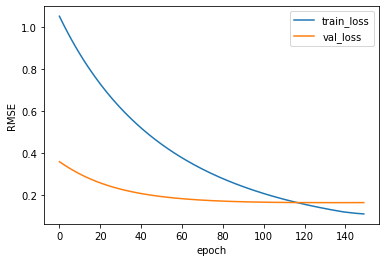

In [ ]:
train_curve(history)

# Summary
#### Random Forest:
Training set RMSE: 0.0979

Test set RMSE: 0.269

Training set R^2: 0.990

Test set R^2: 0.930


#### Neural Network:
Training set RMSE: 0.0895

Test set RMSE: 0.136

Training set R^2: 0.911

Test set R^2: 0.868